In [ ]:
!pip install --upgrade tensorflow==2.12.0 tensorflow-addons==0.21.0
!pip install scikit-learn matplotlib Pillow opencv-python

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet201
import tensorflow_addons as tfa
import numpy as np
import os
import cv2
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from PIL import Image
import zipfile


SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)




/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.12.0


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"doniaahmed789456","key":"ffb5e3066e6a263d2c00c3a2b6af772c"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d ruizgara/socofing
!unzip socofing.zip

Streaming output truncated to the last 5000 lines.
  inflating: socofing/SOCOFing/Real/191__F_Left_index_finger.BMP  
  inflating: socofing/SOCOFing/Real/191__F_Left_little_finger.BMP  
  inflating: socofing/SOCOFing/Real/191__F_Left_middle_finger.BMP  
  inflating: socofing/SOCOFing/Real/191__F_Left_ring_finger.BMP  
  inflating: socofing/SOCOFing/Real/191__F_Left_thumb_finger.BMP  
  inflating: socofing/SOCOFing/Real/191__F_Right_index_finger.BMP  
  inflating: socofing/SOCOFing/Real/191__F_Right_little_finger.BMP  
  inflating: socofing/SOCOFing/Real/191__F_Right_middle_finger.BMP  
  inflating: socofing/SOCOFing/Real/191__F_Right_ring_finger.BMP  
  inflating: socofing/SOCOFing/Real/191__F_Right_thumb_finger.BMP  
  inflating: socofing/SOCOFing/Real/192__M_Left_index_finger.BMP  
  inflating: socofing/SOCOFing/Real/192__M_Left_little_finger.BMP  
  inflating: socofing/SOCOFing/Real/192__M_Left_middle_finger.BMP  
  inflating: socofing/SOCOFing/Real/192__M_Left_ring_finger.BMP  
  i

In [ ]:
# ======================
# 1. Setup & Seed Everything
# ======================
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
# ======================
# 2. Data Preparation
# ======================
def load_fingerprint_data(data_dir):
    """Load fingerprint paths grouped by subject ID"""
    subject_dict = {}
    for filename in os.listdir(data_dir):
        if filename.endswith('.BMP'):
            subject_id = filename.split('__')[0]  # Extract '101' from '101__M_...'
            if subject_id not in subject_dict:
                subject_dict[subject_id] = []
            subject_dict[subject_id].append(os.path.join(data_dir, filename))
    return subject_dict

# Load only Altered-Hard fingerprints
real_dict = load_fingerprint_data("socofing/SOCOFing/Real")
altered_hard_dict = load_fingerprint_data("socofing/SOCOFing/Altered/Altered-Hard")

# Combine all fingerprints (we'll use real+altered as same identity)
subject_dict = {**real_dict, **altered_hard_dict}


In [ ]:
# ======================
# 3. Create Triplet Dataset
# ======================
from tqdm import tqdm

def generate_triplets(subject_dict, num_triplets=10000):
    """Generate anchor, positive, negative triplets"""
    anchors, positives, negatives = [], [], []
    subject_ids = list(subject_dict.keys())

    for _ in tqdm(range(num_triplets), desc="Generating triplets"):
        # Randomly select anchor and positive from same subject
        anchor_subject = random.choice(subject_ids)
        anchor, positive = random.sample(subject_dict[anchor_subject], 2)

        # Select negative from different subject
        negative_subject = random.choice([s for s in subject_ids if s != anchor_subject])
        negative = random.choice(subject_dict[negative_subject])

        anchors.append(anchor)
        positives.append(positive)
        negatives.append(negative)

    return np.array(anchors), np.array(positives), np.array(negatives)

# Generate triplets
anchors, positives, negatives = generate_triplets(subject_dict)

# Split the triplets
(anchors_train, pos_train, neg_train), (anchors_val, pos_val, neg_val), (anchors_test, pos_test, neg_test) = split_triplets(anchors, positives, negatives)

# Now you can print the statistics
print(f"\nTotal triplets generated: {len(anchors)}")
print("\nTriplet dataset split:")
print(f"Train: {len(anchors_train)} triplets")
print(f"Validation: {len(anchors_val)} triplets")
print(f"Test: {len(anchors_test)} triplets")


Generating triplets: 100%|██████████| 10000/10000 [00:00<00:00, 29808.06it/s]


Total triplets generated: 10000

Triplet dataset split:
Train: 7000 triplets
Validation: 1500 triplets
Test: 1500 triplets


In [ ]:
# ======================
# 4. Train/Val/Test Split (70%/15%/15%)
# ======================
def split_triplets(anchors, positives, negatives, test_size=0.15):
    """Split triplets while ensuring no subject overlap"""
    # First split to separate test set
    anchors_train, anchors_test, pos_train, pos_test, neg_train, neg_test = train_test_split(
        anchors, positives, negatives, test_size=test_size, random_state=SEED)

    # Second split to separate val set
    anchors_train, anchors_val, pos_train, pos_val, neg_train, neg_val = train_test_split(
        anchors_train, pos_train, neg_train, test_size=test_size/(1-test_size), random_state=SEED)

    return (anchors_train, pos_train, neg_train), (anchors_val, pos_val, neg_val), (anchors_test, pos_test, neg_test)

(anchors_train, pos_train, neg_train), (anchors_val, pos_val, neg_val), (anchors_test, pos_test, neg_test) = split_triplets(anchors, positives, negatives)


In [ ]:
# ======================
# 5. Data Pipeline
# ======================
def preprocess_image(path, img_size=(96, 96)):
    """Load and preprocess single image"""
    img = tf.io.read_file(path)
    img = tf.image.decode_bmp(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, 0.1)
    img = tf.cast(img, tf.float32) / 255.0
    return img

def create_triplet_dataset(anchors, positives, negatives, batch_size=32):
    """Create TensorFlow dataset for triplets"""
    def map_fn(anchor, positive, negative):
        return (
            preprocess_image(anchor),
            preprocess_image(positive),
            preprocess_image(negative)
        )

    dataset = tf.data.Dataset.from_tensor_slices((anchors, positives, negatives))
    dataset = dataset.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

train_ds = create_triplet_dataset(anchors_train, pos_train, neg_train)
val_ds = create_triplet_dataset(anchors_val, pos_val, neg_val)
test_ds = create_triplet_dataset(anchors_test, pos_test, neg_test)


In [ ]:
# ======================
# 6. Siamese Network with DenseNet201
# ======================

from tensorflow.keras.applications import DenseNet201

def build_embedding_model():
    """Shared CNN for generating embeddings"""
    base_model = DenseNet201(
    include_top=False,
    weights='imagenet',
    input_shape=(96, 96, 3)
)

    base_model.trainable = True  # Fine-tune entire model

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation=None),  # No activation for metric learning
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))  # L2 normalize embeddings
    ])
    return model

embedding_model = build_embedding_model()

74836368/74836368 [==============================] - 0s 0us/step


In [ ]:
# ======================
# 7. Triplet Loss
# ======================
class TripletLoss(tf.keras.losses.Loss):
    def __init__(self, margin=0.5, **kwargs):
        super().__init__(**kwargs)
        self.margin = margin

    def call(self, y_true, y_pred):
        anchor, positive, negative = y_pred[:,0], y_pred[:,1], y_pred[:,2]

        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)

        basic_loss = pos_dist - neg_dist + self.margin
        loss = tf.maximum(basic_loss, 0.0)
        return tf.reduce_mean(loss)

In [ ]:
# ======================
# 8. Siamese Model
# ======================
class SiameseModel(tf.keras.Model):
    def __init__(self, embedding_model, margin=0.5, **kwargs):
        super().__init__(**kwargs)
        self.embedding_model = embedding_model
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.margin = margin

    def call(self, inputs):
        anchor, positive, negative = inputs
        return (
            self.embedding_model(anchor),
            self.embedding_model(positive),
            self.embedding_model(negative))

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        anchor, positive, negative = data
        anchor_embed = self.embedding_model(anchor, training=True)
        positive_embed = self.embedding_model(positive, training=True)
        negative_embed = self.embedding_model(negative, training=True)

        pos_dist = tf.reduce_sum(tf.square(anchor_embed - positive_embed), axis=1)
        neg_dist = tf.reduce_sum(tf.square(anchor_embed - negative_embed), axis=1)
        loss = tf.maximum(pos_dist - neg_dist + self.margin, 0.0)
        return tf.reduce_mean(loss)

In [ ]:
# ======================
# 9. Training with Model Checkpoint
# ======================
siamese_model = SiameseModel(embedding_model, margin=0.5)
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5))

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_siamese_model.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True)

history = siamese_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1,
    callbacks=[checkpoint, early_stopping])

219/219 [==============================] - ETA: 0s - loss: 0.4125 

219/219 [==============================] - 4001s 18s/step - loss: 0.4125 - val_loss: 0.3619


In [ ]:
# ======================
# 10. Evaluation
# ======================
def evaluate_model(model, dataset):
    """Evaluate verification accuracy and AUC"""
    # Initialize model by processing a batch first
    for batch in dataset.take(1):
        model(batch)

    # Now load weights
    model.load_weights("best_siamese_model.h5")

    # Rest of the evaluation code remains the same
    pos_dists, neg_dists = [], []
    for anchor, positive, negative in tqdm(dataset, desc="Evaluating"):
        a_emb = model.embedding_model(anchor)
        p_emb = model.embedding_model(positive)
        n_emb = model.embedding_model(negative)

        pos_dists.extend(tf.reduce_sum(tf.square(a_emb - p_emb), axis=1).numpy())
        neg_dists.extend(tf.reduce_sum(tf.square(a_emb - n_emb), axis=1).numpy())

    y_true = np.concatenate([np.ones_like(pos_dists), np.zeros_like(neg_dists)])
    y_scores = np.concatenate([pos_dists, neg_dists])

    fpr, tpr, thresholds = roc_curve(y_true, -y_scores)
    roc_auc = auc(fpr, tpr)

    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = -thresholds[optimal_idx]
    y_pred = (y_scores < optimal_threshold).astype(int)
    accuracy = accuracy_score(y_true, y_pred)

    return accuracy, roc_auc, fpr, tpr

Evaluating: 100%|██████████| 47/47 [03:07<00:00,  3.99s/it]



Final Performance:
Train Accuracy: 0.7026 | AUC: 0.7729
Val Accuracy: 0.6480 | AUC: 0.6940
Test Accuracy: 0.6307 | AUC: 0.6799


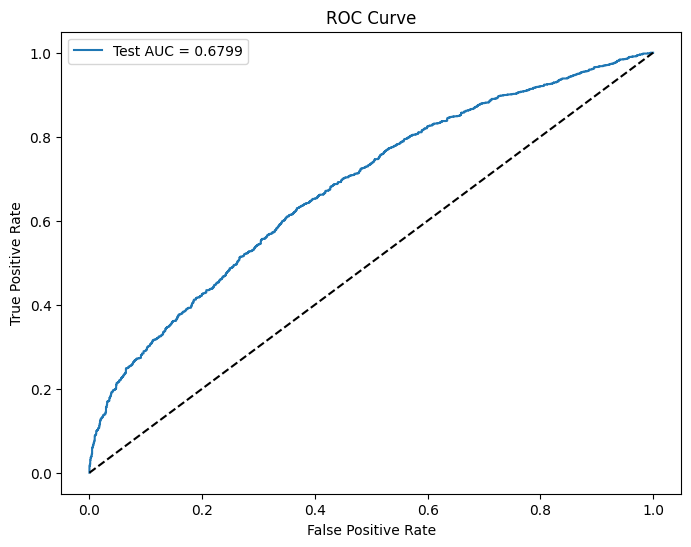

In [ ]:
# ======================
# 10. Evaluation
# ======================
def evaluate_model(model, dataset):
    """Evaluate verification accuracy and AUC"""
    # Initialize model by processing a batch first
    for batch in dataset.take(1):
        model(batch)

    # Now load weights
    model.load_weights("best_siamese_model.h5")

    # Rest of the evaluation code remains the same
    pos_dists, neg_dists = [], []
    for anchor, positive, negative in tqdm(dataset, desc="Evaluating"):
        a_emb = model.embedding_model(anchor)
        p_emb = model.embedding_model(positive)
        n_emb = model.embedding_model(negative)

        pos_dists.extend(tf.reduce_sum(tf.square(a_emb - p_emb), axis=1).numpy())
        neg_dists.extend(tf.reduce_sum(tf.square(a_emb - n_emb), axis=1).numpy())

    y_true = np.concatenate([np.ones_like(pos_dists), np.zeros_like(neg_dists)])
    y_scores = np.concatenate([pos_dists, neg_dists])

    fpr, tpr, thresholds = roc_curve(y_true, -y_scores)
    roc_auc = auc(fpr, tpr)

    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = -thresholds[optimal_idx]
    y_pred = (y_scores < optimal_threshold).astype(int)
    accuracy = accuracy_score(y_true, y_pred)

    return accuracy, roc_auc, fpr, tpr

# Evaluate on all splits
train_acc, train_auc, _, _ = evaluate_model(siamese_model, train_ds.take(1000))  # Use subset for faster eval
val_acc, val_auc, _, _ = evaluate_model(siamese_model, val_ds)
test_acc, test_auc, fpr, tpr = evaluate_model(siamese_model, test_ds)

print("\nFinal Performance:")
print(f"Train Accuracy: {train_acc:.4f} | AUC: {train_auc:.4f}")
print(f"Val Accuracy: {val_acc:.4f} | AUC: {val_auc:.4f}")
print(f"Test Accuracy: {test_acc:.4f} | AUC: {test_auc:.4f}")

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Test AUC = {test_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()